In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


plt.style.use("ggplot")

import torch
# import torch.nn as nn
import torchvision.transforms as transforms

import gc
import os
import time
import random
from datetime import datetime
from data_processing.data_generator import DataLoader

from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#import albumentations as albu
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import layers

In [2]:
DATA_PATH = "../input/cassava-leaf-disease-classification"
TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images/"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images/"
MODEL_PATH = (
    "../input/vit-base-models-pretrained-pytorch/jx_vit_base_p16_224-80ecf9dd.pth"
)

In [ ]:
# df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
# df.head()

In [5]:

(X, y), (X_test, y_test) = cifar100.load_data(label_mode="coarse")

169009152/169001437 [==============================] - 359s 2us/step


In [ ]:
# n_classes = 20
# class_plotted = np.random.choice(range(n_classes), 5, replace = False)
# print(class_plotted)
# print(y.reshape(-1))


In [6]:
# print("The shape of X_train : ", X.shape)
# print("The shape of X_test : ", X_test.shape)

In [4]:
dl = DataLoader()

In [5]:
trainData = dl.trainData
metaData = dl.metaData
#type of items in each file
for item in trainData:
    print(item, type(trainData[item]))

filenames <class 'list'>
batch_label <class 'str'>
fine_labels <class 'list'>
coarse_labels <class 'list'>
data <class 'numpy.ndarray'>


In [6]:

print("Fine labels:", metaData['fine_label_names'], "\n")
print("Coarse labels:", metaData['coarse_label_names'])

Fine labels: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', '

In [8]:
category = pd.DataFrame(metaData['coarse_label_names'], columns=['SuperClass'])
print(category)

                        SuperClass
0                  aquatic_mammals
1                             fish
2                          flowers
3                  food_containers
4             fruit_and_vegetables
5     household_electrical_devices
6              household_furniture
7                          insects
8                 large_carnivores
9    large_man-made_outdoor_things
10    large_natural_outdoor_scenes
11  large_omnivores_and_herbivores
12                  medium_mammals
13        non-insect_invertebrates
14                          people
15                        reptiles
16                   small_mammals
17                           trees
18                      vehicles_1
19                      vehicles_2


In [9]:
X_train = trainData['data']
X_train = X_train.reshape(len(X_train),3,32,32).transpose(0,2,3,1)

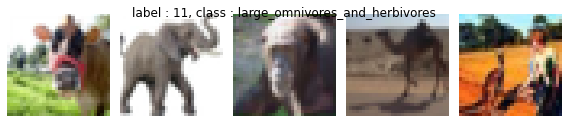

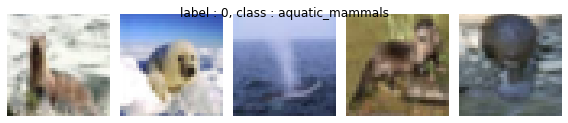

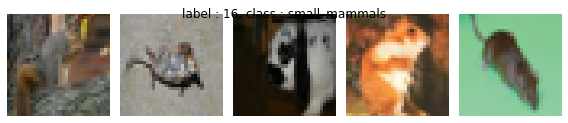

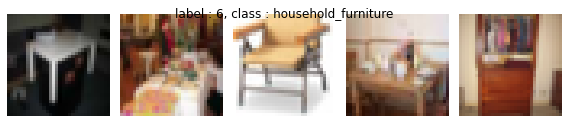

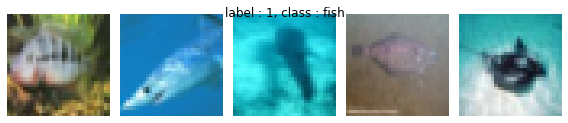

In [10]:
class_plotted = np.random.choice(range(20), 5, replace = False)
for i in range(len(class_plotted)):
    image_samples = X_train[trainData['coarse_labels'] == class_plotted[i]][:5]
    fig, ax = plt.subplots(nrows = 1, ncols = 5,figsize = (8,8))
    fig.suptitle("label : %d, class : %s" % (class_plotted[i], metaData['coarse_label_names'][class_plotted[i]]), y = .6)
    for j in range(5):
        ax[j].imshow(image_samples[j])
        ax[j].axis('off')  
    fig.tight_layout()
plt.show()

In [13]:
st = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 1)
for train_index, val_index in st.split(X, y):
    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
    
print("The number of training data : ", X_train.shape[0])
print("The number of validation data : ", X_val.shape[0])

#del X, y

The number of training data :  40000
The number of validation data :  10000


In [14]:
#unused
def np_resize(img, shape):
    return cv2.resize(img, (shape[1], shape[0]), interpolation = cv2.INTER_CUBIC)

In [15]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 24  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [16]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 72 X 72
Patch size: 24 X 24
Patches per image: 9
Elements per patch: 1728


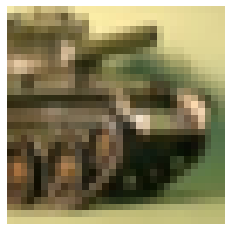

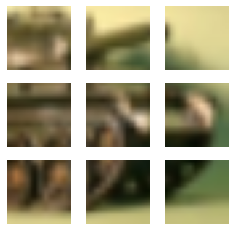

In [17]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
#Sequence of patches (Positional Embedding)


# ResNet (include_top)